# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.sigp_AP as sigp_AP
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=2)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.34:8787/status,
Dashboard: http://10.148.0.34:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.34:37112,Workers: 0
Dashboard: http://10.148.0.34:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [4]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



In [5]:
dt = 1/24 # time step in days

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)
#print('omega (M2+S2)/2:%s'%(omega_M2+omega_S2)/2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [6]:
h = generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)

In [7]:
h_hat, w = filter_response(h, dt)

No handles with labels found to put in legend.


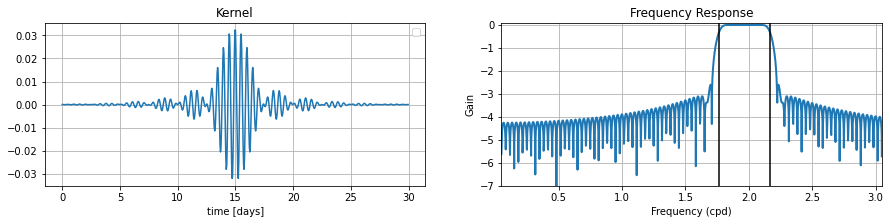

In [8]:
t = np.arange(0,30,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband, color='k')
ax.axvline(omega+dband, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [9]:
# generate synthetic data
#T,T_low = [14,29,80],10

def rename_attrs(da, **kwargs):
    """ rename attributes
    """
    for k_new, k_old in kwargs.items():
        da = da.assign_attrs(**{k_new: da.attrs.pop(k_old)})
    return da

def tseries(kind, params={}, **kwargs):
    _kwargs = dict(time=(t_size, 1/24), 
                   seed=0,
                  )
    _kwargs.update(**kwargs)
    #               T=10.,
    if kind=="high_M2":
        p = dict(U=[1.], T=T, sigma=omega_M2*rad) #[0.01, 0.05,.1, 1.]
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
#        da = (#rename_attrs(da, T_high="T")
#              da.rename(U='U_high')
#            )
    elif kind=="high_S2":
        p = dict(U=[1.], T=T, sigma=omega_S2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
#        da = (#rename_attrs(da, T_high="T")
#              da.rename(U='U_high')
#             )
    elif kind=="high_N2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_N2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    elif kind=="high_K2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_K2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    else:
        p = dict(T=T_low)
        p.update(**params)
        da = (u_low
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = rename_attrs(da, U_low="U") #T_low="T"
    return da

In [10]:
def autocorrelations(ds, V,combine=False,maxlag=None,lags=None,**kwargs):
#    V = ["high", "low"]
#    if combine:
#        ds["sum"] = ds["high"]  + ds["low"]
#        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
#        V = V + ["sum"]
    R = []
    for v in V:
        if v=='low':
            R.append((sigp
                  .correlate(ds[v].real, ds[v].real,maxlag=maxlag,lags=lags,**kwargs)
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
        else:
            R.append((sigp
                      .correlate(ds[v+"_demodulated"].real, ds[v+"_demodulated"].real,maxlag=maxlag,lags=lags,**kwargs)
                      .rename(v)
                      .to_dataset()
                      .rename({'lags': 'tau'})
                     )
                    )
    return xr.merge(R)

In [11]:
t_size=500
T,T_low = [10],[10]#[5,15,30,80],[5,30,100]
U_high = [0.1]#[0.01,0.05,0.1,1.]
Tw = [30]#[15,30,60]
dband = [0.2]#[0.05,0.1,0.2,0.3]
nb_draws = 500

### Test case (notebook aurélien)

In [11]:
from sstats import models
mu=0 # true mean
sigma0 = 0.1 # true variance
T = 10 # days, decorrelation timescale

delta_T = 100 # time series length
#delta_T = 300 # time series length
dt = 3/24 # sampling interval in days
Nw0 = 10 # number of windows averaged in the nominal case
Nw = [2, 5, 10, 20, 40]


# generate time series
u = mu + ts.exp_autocorr((delta_T, dt), T, 
                         np.sqrt(sigma0), 
                         #burnin=int(10*T/dt),
                         draws=1000, 
                         seed=0,
                        ).compute()

## derived parameters:
sigma_true = lambda tau: models["exp"]["sigma"](tau, sigma0, T)
gamma_true = lambda tau: models["exp"]["gamma"](tau, sigma0, T)

# total number of points
N = u.time.size # = delta_T/dt 

# get effective DOF
mean_Ne, sigma0_Ne, sigma0_scale = sigp_AP.effective_DOF(sigma_true, dt, N)

In [20]:
ds = sigp_AP.svariance(u, "time").rename("gamma_hat").to_dataset()
ds["gamma"] = ("lags", gamma_true(ds.lags.values))

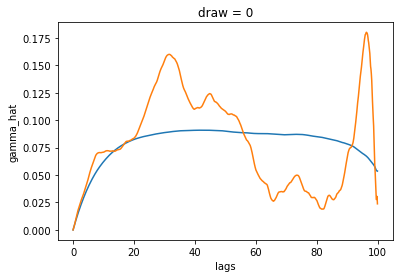

In [34]:
ds.gamma_hat.mean('draw').plot()
ds.gamma_hat.sel(draw=0).plot()

<xarray.DataArray 'z' (time: 800, draw: 1000)>
array([[ 0.08820262,  0.02000786,  0.0489369 , ...,  0.00470962,
        -0.05738055, -0.0179057 ],
       [ 0.11489822,  0.06438146,  0.02720945, ...,  0.01257244,
        -0.11375836, -0.0832304 ],
       [ 0.03681594, -0.02202182,  0.02917608, ...,  0.00279507,
        -0.17296217, -0.08621995],
       ...,
       [-0.162505  , -0.28180597, -0.03017398, ...,  0.03118887,
         0.22987405, -0.40935135],
       [-0.16112498, -0.35443968,  0.02264232, ..., -0.04240029,
         0.24054048, -0.37175664],
       [-0.12980094, -0.32721952, -0.02777196, ..., -0.04312146,
         0.28296871, -0.33083331]])
Coordinates:
  * time     (time) float64 0.0 0.125 0.25 0.375 0.5 ... 99.5 99.62 99.75 99.88
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999


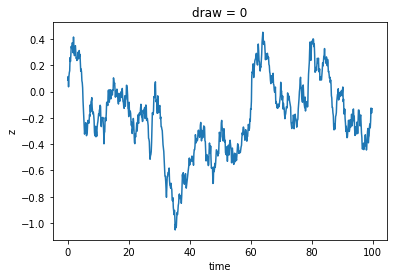

In [35]:
print(u)
u.sel(draw=0).plot()

### Coherent signal : 

In [19]:
def generate_timeseries(delta_T, n_draws, T, sigma0, seed, filtering = True, chunks=dict(T=-1)):
    u = mu + ts.exp_autocorr((delta_T, dt), T, 
                             np.sqrt(sigma0), 
                         #    burnin=int(10*T_all[-1]/dt),
                             draws=n_draws,
                             seed=seed,
                             chunks=chunks,
                            )
    ds = u.rename("u").to_dataset()
    # low-pass filter
    if filtering:
        ds["u_bar"] = sigp.filt(ds.u, filter_h)    
    return ds

In [21]:
delta_T = 300 # time series length in days
n_draws = 500 # number of draws
T_all = 10#[0.5*T, T, 2*T]
sigma0 = 1
mu = 0
ds_low = generate_timeseries(delta_T, n_draws, T_all, sigma0,seed=0,filtering=False)

In [27]:
i,j = 1,2
ds_hf = {}
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf_real = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=i)
    ds_hf_imag = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=i)
    ds_hf[c] = (ds_hf_real/np.sqrt(2)*np.exp(1j*om*rad*ds_hf_real['u'].time)+1j*ds_hf_imag/np.sqrt(2)*np.exp(1j*(om*rad)*ds_hf_real['u'].time)).u
    ds_hf[c] = ds_hf[c].chunk({'time':-1,'draw':-1})
    i+=2
   # j+=2
ds_hf

{'M2': <xarray.DataArray 'u' (time: 7200, draw: 500)>
 dask.array<add, shape=(7200, 500), dtype=complex128, chunksize=(7200, 500), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
   * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499,
 'S2': <xarray.DataArray 'u' (time: 7200, draw: 500)>
 dask.array<add, shape=(7200, 500), dtype=complex128, chunksize=(7200, 500), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
   * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499}

In [28]:
sigma = [0.01,0.1,1.,2.]
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf[c] = xr.concat([np.sqrt(u)*ds_hf[c] for u in sigma],dim='rms').assign_coords({'rms':sigma})
    ds_hf[c+'_coh'] = xr.concat([np.sqrt(u)*np.exp(1j*om*rad*ds_hf_real['u'].time
                                                  ) for u in sigma],dim='rms').assign_coords({'rms':sigma})

In [29]:
ds_hf['high_MS'] = ds_hf['M2']+ds_hf['S2']

In [30]:
ds_hf['high_MS_coh'] = ds_hf['M2_coh']+ds_hf['S2_coh']

ds_hf['M2_mix'] = ds_hf['M2']/np.sqrt(2)+ds_hf['M2_coh']/np.sqrt(2)
ds_hf['S2_mix'] = ds_hf['S2']/np.sqrt(2)+ds_hf['S2_coh']/np.sqrt(2)
ds_hf['high_MS_mix'] = ds_hf['M2_mix']+ds_hf['S2_mix']

In [31]:
exp_M2_demod = np.exp(-1j*omega_M2*rad*ds_hf['M2'].time)
exp_S2_demod = np.exp(-1j*omega_S2*rad*ds_hf['S2'].time)
exp_MS_demod = np.exp(-1j*omega*rad*ds_hf['S2'].time)

In [32]:
p = '_coh'
for c,exp in zip(['M2','S2','high_MS'],[exp_M2_demod,exp_S2_demod,exp_MS_demod]):
    ds_hf[c+p+'_analytical'] = xr.DataArray(signal.hilbert(ds_hf[c+p].real)
                                            ,coords={"rms":sigma,"time":ds_hf['M2'].time})
    #    ds_hf[c+p+'_analytical'] = ds_hf[c+p].real+
    ds_hf[c+p+'_demodulated'] = ds_hf[c+p]*exp
    ds_hf[c+p+'_demodulated_bis'] = ds_hf[c+p+'_analytical']*exp

In [34]:
for c,exp in zip(['M2','S2','high_MS'],[exp_M2_demod,exp_S2_demod,exp_MS_demod]):
    for p in ['_mix','']:
        ds_hf[c+p+'_analytical'] = xr.DataArray(signal.hilbert(ds_hf[c+p].real),
                                                coords={"rms":sigma,#"T":T_all,
                                                        "time":ds_hf['M2'].time,
                                                        "draw":ds_hf['M2'].draw})
    #    ds_hf[c+p+'_analytical'] = ds_hf[c+p].real+
        ds_hf[c+p+'_demodulated'] = ds_hf[c+p]*exp
        ds_hf[c+p+'_demodulated_bis'] = ds_hf[c+p+'_analytical']*exp

In [37]:
test = ds_hf['M2_demodulated'].compute()

In [47]:
test.sel(rms=1).rename('u').name

'u'

In [46]:
import sstats.sigp_AP as sigp
sigp.svariance(test.sel(rms=1).rename('u'),"time")#.rename("gammma_hat").to_dataset()

TypeError: ufunc '_svariance_np_gufunc' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [22]:
u = hf.high_frequency_signal(stationary=True)

In [25]:
rad = 2*np.pi
p = dict(U=0., Us=1., T=10., sigma=omega_M2*rad)

u_M2 = generate_timeseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='M2'
                        ).persist()


p = dict(U=0., Us=1., T=10., sigma=omega_S2*rad)

u_S2 = generate_timeseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='S2'
                        ).persist()

u_low = hf.low_frequency_signal()
low = tseries("low",draws=nb_draws,name='low').persist()

TypeError: generate_timeseries() got an unexpected keyword argument 'params'

In [14]:
u_M2 = u_M2.compute()

u_S2 = u_S2.compute()
low = low.compute()

In [ ]:
rad = 2*np.pi
p = dict(U=0.5, Us=.5, T=10., sigma=omega_M2*rad)

u_mix_M2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='M2'
                        ).persist()


p = dict(U=0.5, Us=.5, T=10., sigma=omega_S2*rad)

u_mix_S2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='S2'
                        ).persist()


In [48]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [15]:
u_high = u_S2+u_M2
u_total = u_S2+u_M2+low

u_mix_high = u_mix_S2+u_mix_M2
u_mix_total = u_mix_S2+u_mix_M2+low

In [16]:
exp_M2 = np.exp(-1j*omega_M2*np.arange(0,t_size,1/24))
exp_S2 = np.exp(-1j*omega_S2*np.arange(0,t_size,1/24))
exp = np.exp(-1j*(omega_M2+omega_S2)/2*np.arange(0,t_size,1/24))


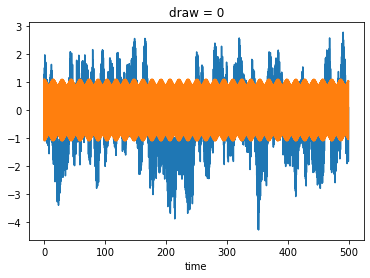

In [17]:
u_total.sel(draw=0).plot()
u_high.sel(draw=0).plot()

In [18]:
print(u,u_high)

<sstats.hfreq.high_frequency_signal object at 0x2aaad6822280> <xarray.DataArray (time: 12000, draw: 500)>
array([[1.1       , 1.1       , 1.1       , ..., 1.1       , 1.1       ,
        1.1       ],
       [0.96135672, 0.96135672, 0.96135672, ..., 0.96135672, 0.96135672,
        0.96135672],
       [0.58038974, 0.58038974, 0.58038974, ..., 0.58038974, 0.58038974,
        0.58038974],
       ...,
       [0.79120491, 0.79120491, 0.79120491, ..., 0.79120491, 0.79120491,
        0.79120491],
       [1.03844727, 1.03844727, 1.03844727, ..., 1.03844727, 1.03844727,
        1.03844727],
       [1.02469438, 1.02469438, 1.02469438, ..., 1.02469438, 1.02469438,
        1.02469438]])
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499


In [19]:
N = low.time.size

In [ ]:
ds_low = sigp_AP.svariance(low, "time").rename("gamma_hat").to_dataset()

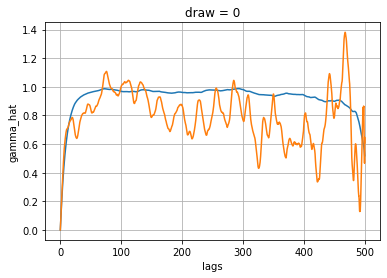

In [49]:
ds_low.gamma_hat.mean('draw').plot()
ds_low.gamma_hat.sel(draw=0).plot()
plt.grid()

In [51]:
Nw0 = t_size//10
dsw = ds_low.coarsen(draw=Nw0).mean()

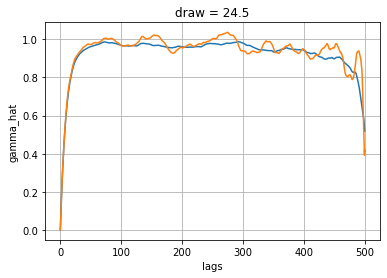

In [54]:
dsw.gamma_hat.mean('draw').plot()
dsw.gamma_hat.isel(draw=0).plot()
plt.grid()

In [20]:
u_total = u_total.rename('total')
u_high = u_high.rename('high')

In [ ]:
ds_high = sigp_AP.svariance(u_high,"time").rename("gammma_hat").to_dataset()
dsw_high = ds_high.coarsen(int(t_size/10)).mean()


In [27]:
ds_total = sigp_AP.svariance(u_total, "time").rename("gamma_hat").to_dataset()

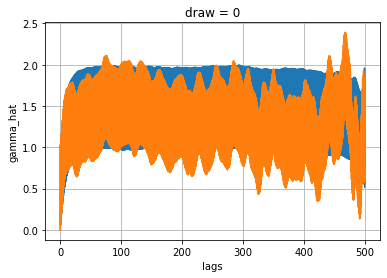

In [28]:
ds_total.gamma_hat.mean('draw').plot()
ds_total.gamma_hat.sel(draw=0).plot()
plt.grid()

In [30]:
dsw_total = ds_total.coarsen(draw = int(t_size/10)).mean()

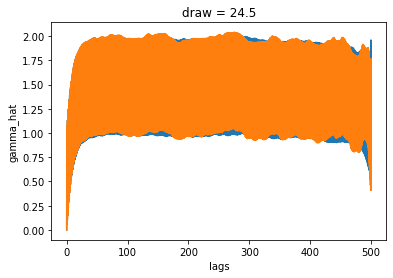

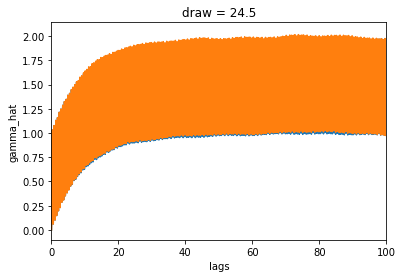

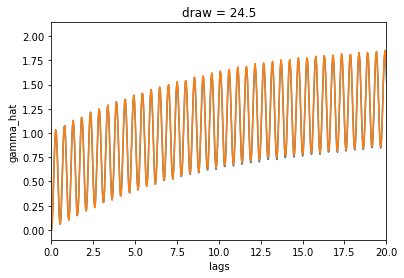

In [33]:
dsw_total.gamma_hat.mean('draw').plot()
dsw_total.gamma_hat.isel(draw=0).plot()

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,100))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,100))
plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,20))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,20))

In [22]:
u_high_filtered = sigp_AP.bpass_demodulate(u_high,omega,0.2,30)
u_total_filtered = sigp_AP.bpass_demodulate(u_total,omega,0.2,30)

In [27]:
ds_demodulated = sigp_AP.svariance(u_total_filtered[0].demodulated.real, "time").rename("gamma_hat").to_dataset()

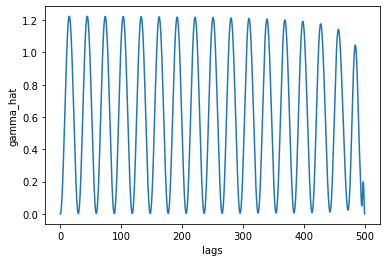

In [29]:
ds_demodulated.gamma_hat.mean('draw').plot()

In [43]:
rad = 2*np.pi
p = dict(U=0.5, Us=.5, T=10., sigma=omega_M2*rad)

u_M2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='M2'
                        ).compute()


p = dict(U=0.5, Us=.5, T=10., sigma=omega_S2*rad)

u_S2 = u.generate_tseries(params=p, 
                         seed=0,
                         time=(t_size,1/24),
                         draws=nb_draws,name='S2'
                        ).compute()

u_low = hf.low_frequency_signal()
low = tseries("low",draws=nb_draws,name='low').compute()

In [44]:
u_high = u_M2+u_S2
u_total = u_M2+u_S2+low

In [45]:
u_high = u_high.rename('high')
u_total = u_total.rename('total')

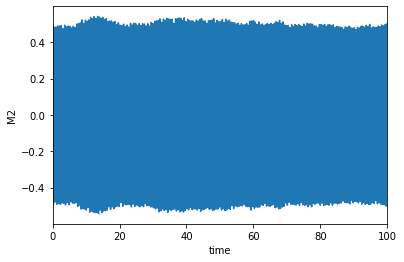

In [56]:
u_M2.mean('draw').plot(xlim=(0,100))

In [34]:
ds_high = sigp_AP.svariance(u_high,"time").rename("gammma_hat").to_dataset()
#dsw_high = ds_high.coarsen(int(t_size/10)).mean()

In [36]:
ds_high

<xarray.Dataset>
Dimensions:     (draw: 500, lags: 12000)
Coordinates:
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * lags        (lags) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    N           (lags) int64 12000 11999 11998 11997 11996 11995 ... 5 5 4 2 2 1
Data variables:
    gammma_hat  (draw, lags) float64 0.0 0.05064 0.1858 ... 1.087 1.202 1.098

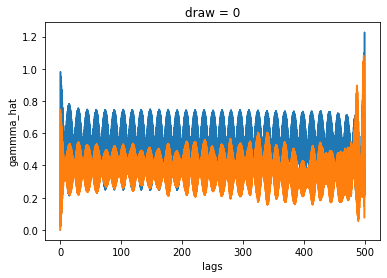

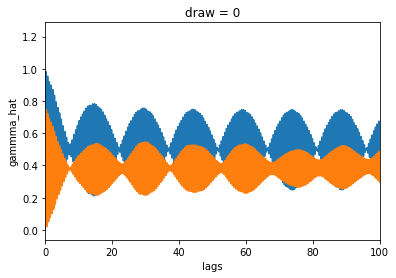

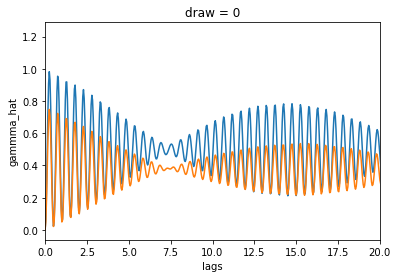

In [37]:
ds_high.gammma_hat.mean('draw').plot()
ds_high.gammma_hat.sel(draw=0).plot()

plt.figure()
ds_high.gammma_hat.mean('draw').plot(xlim=(0,100))
ds_high.gammma_hat.sel(draw=0).plot(xlim=(0,100))

plt.figure()
ds_high.gammma_hat.mean('draw').plot(xlim=(0,20))
ds_high.gammma_hat.sel(draw=0).plot(xlim=(0,20))

In [46]:
u_high_filtered = sigp_AP.bpass_demodulate(u_high,omega,0.2,30)
u_total_filtered = sigp_AP.bpass_demodulate(u_total,omega,0.2,30)

In [47]:
ds_total = sigp_AP.svariance(u_total_filtered[0].demodulated.real,"time").rename("gamma_hat").to_dataset()

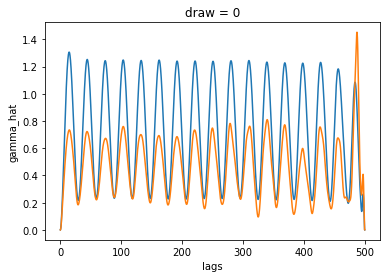

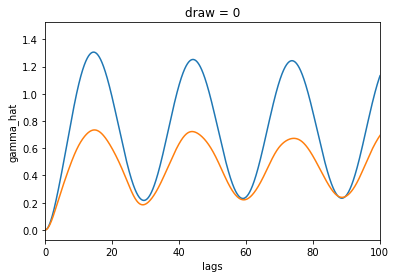

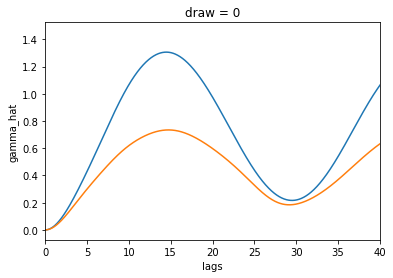

In [48]:
ds_total.gamma_hat.mean('draw').plot()
ds_total.gamma_hat.sel(draw=0).plot()

plt.figure()
ds_total.gamma_hat.mean('draw').plot(xlim=(0,100))
ds_total.gamma_hat.sel(draw=0).plot(xlim=(0,100))

plt.figure()
ds_total.gamma_hat.mean('draw').plot(xlim=(0,40))
ds_total.gamma_hat.sel(draw=0).plot(xlim=(0,40))

In [50]:
dsw_total = ds_total.coarsen(draw=int(t_size/10)).mean()

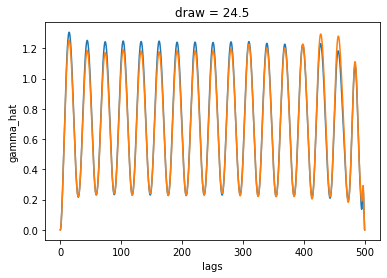

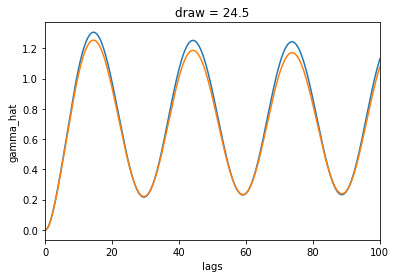

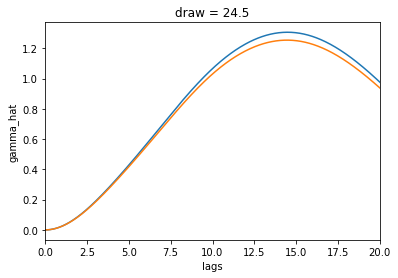

In [52]:
dsw_total.gamma_hat.mean('draw').plot()
dsw_total.gamma_hat.isel(draw=0).plot()

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,100))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,100))

plt.figure()
dsw_total.gamma_hat.mean('draw').plot(xlim=(0,20))
dsw_total.gamma_hat.isel(draw=0).plot(xlim=(0,20))

In [25]:
kind = ['M2','S2','high','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]

In [18]:
ds = xr.merge([u_M2,u_S2,u_high.rename('high'),u_total.rename('total')])
ds

<xarray.Dataset>
Dimensions:  (T: 3, draw: 30, time: 24000)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * T        (T) int64 5 30 100
Data variables:
    M2       (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    S2       (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    high     (time, draw) float64 dask.array<chunksize=(24000, 30), meta=np.ndarray>
    total    (time, draw, T) float64 dask.array<chunksize=(24000, 30, 3), meta=np.ndarray>

In [19]:
kind = ['M2','S2','high','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]



In [22]:
R = {}
maxlag=1000
lags= np.arange(0,maxlag//2,1/24)
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R[k] = autocorrelations(_ds[k],[k],maxlag=None,lags = lags,**{'mode':'same'})

In [23]:
ds_R = xr.merge([R[k] for k in kind])

In [24]:
ds_R_mean = ds_R.mean('draw').compute()

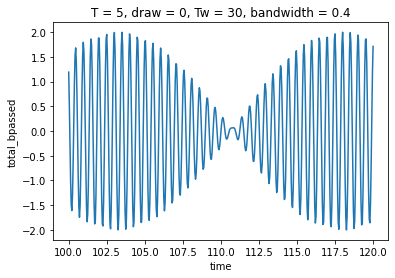

In [25]:
_ds['total'].total_bpassed.real.sel(draw=0,Tw=30,T=5,bandwidth=0.4).sel(time=slice(100,120)).plot()

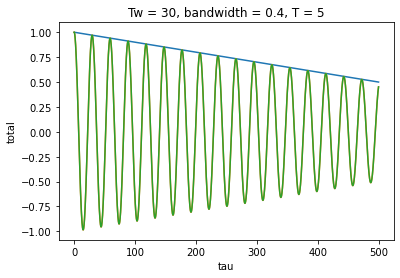

In [26]:
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean.high/ds_R_mean.high.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean.total/ds_R_mean.total.isel(tau=0)).sel(bandwidth=0.4,Tw=30,T=5).plot()

Notes : 
Pas de contamination par la basse fréquence.

In [27]:
R_valid = {}
maxlag=1000
lags= np.arange(0,maxlag//2,1/24)
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R_valid[k] = autocorrelations(_ds[k],[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})

In [28]:
ds_R_valid = xr.merge([R_valid[k] for k in kind])

In [29]:
ds_R_mean_valid = ds_R_valid.mean('draw').compute()

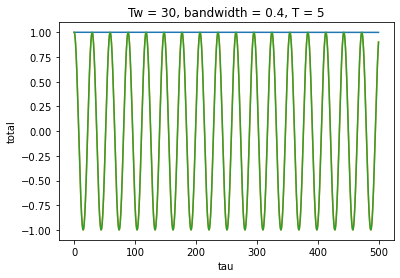

In [30]:
(ds_R_mean_valid.M2/ds_R_mean_valid.M2.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean_valid.high/ds_R_mean_valid.high.isel(tau=0)).sel(bandwidth=0.4,Tw=30).plot()
(ds_R_mean_valid.total/ds_R_mean_valid.total.isel(tau=0)).sel(bandwidth=0.4,Tw=30,T=5).plot()

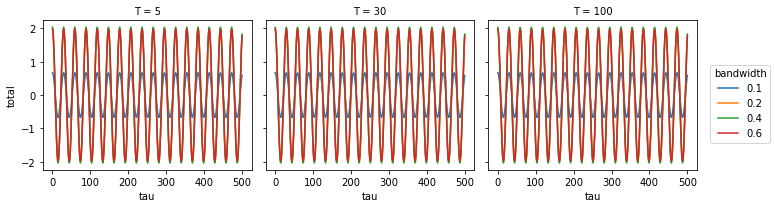

In [35]:
ds_R_mean_valid.total.sel(Tw=30).plot(col='T',hue='bandwidth')

In [31]:
ds_R_mean.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_30_same.nc')
ds_R_mean_valid.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_30_valid.nc')

###  Incoherent signal : 1 draw

In [12]:
# actually generate time series

u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
da_high_M2 = tseries("high_M2",draws=1,name='high_M2').persist()
#da_high_M2 = da_high_M2.rename('high_M2')
da_high_S2 = tseries("high_S2",draws=1,name='high_S2').persist()
#da_high_S2 = da_high_S2.rename('high_S2')
#da_high_N2 = tseries("high_N2",draws=1).persist()
#da_high_N2 = da_high_N2.rename('high_N2')
#da_high_K2 = tseries("high_K2",draws=1).persist()
#da_high_K2 = da_high_K2.rename('high_K2')


da_low = tseries("low",draws=1).persist()

In [13]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma']}

#da_high_N2.attrs = {'sigma_N2':da_high_N2.attrs['sigma']}
#da_high_K2.attrs = {'sigma_K2':da_high_K2.attrs['sigma']}

#ds = xr.merge([da_high_M2,da_high_S2,da_high_N2,da_high_K2, da_low.rename({'T':'T_low'})]) #, combine_attrs="no_conflicts"
#ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})])

#ds

In [14]:
da_high_M2 = xr.concat([da_high_M2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
da_high_S2 = xr.concat([da_high_S2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})])
ds

<xarray.Dataset>
Dimensions:  (T: 5, T_low: 3, U_high: 4, time: 24000)
Coordinates:
  * T        (T) int64 5 10 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100
Data variables:
    high_M2  (U_high, T, time) float64 dask.array<chunksize=(1, 5, 24000), meta=np.ndarray>
    high_S2  (U_high, T, time) float64 dask.array<chunksize=(1, 5, 24000), meta=np.ndarray>
    low      (T_low, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>

In [15]:
ds['high_MS'] = ds.high_M2+ds.high_S2
#ds['high_MSNK'] = ds.high_M2+ds.high_S2+ds.high_N2+ds.high_K2
ds['total'] = ds.high_M2+ds.high_S2+ds.low

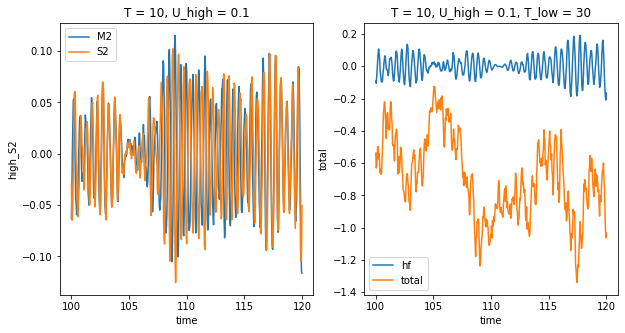

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds.high_M2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='M2')
ds.high_S2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='S2')
ax[0].legend()
ds.high_MS.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='hf')
ds.total.isel(T_low=1,T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='total')
ax[1].legend()

#### Filter and demodulation : 
Band pass filter applied to signal : 
1) monochromatic signal, M2 frequency

2) monochromatic signal, S2 frequency 

3) superpostion of S2 and M2 ; central frequency is the mean frequency

4) total signal (M2+S2+lf) ; central frequency is the mean frequency

Notes on paramters : 

1) halfbandwidth, $d\omega$, should be defined such as : $1/d\omega\geq T_w$; where $T_w$ is the kernel length

2) $d\omega\geq \tilde T$ ; where $\tilde T$ is the hf decorrelation timescale.

In [17]:

kind = ['high_M2','high_S2','high_MS','total'] #'high_MSNK',
_ds,h = {},{}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})
    h[k] = [[sigp.bpass_demodulate(ds[[k]], om, band, tw)[1] for tw in Tw] for band in dband]


In [18]:
_ds['low'] = ds.low

In [19]:
maxlag=t_size
lags= np.arange(0,maxlag//2,1/24)
R = {}
#kind = ['high_M2','high_S2','high_MS','high_MSNK','total']
for k in kind:
    R[k] = autocorrelations(_ds[k],[k],maxlag = maxlag,lags=lags,**{'mode':'valid'})

In [20]:
ds_R = xr.merge([R[k] for k in kind])

In [21]:
ds_R = ds_R.compute()

In [26]:
R_low = autocorrelations(_ds,['low'],maxlag=maxlag,lags=lags,**{'mode':'valid'})
dsR_low = R_low.compute()

In [27]:
ds_R = xr.merge([ds_R,dsR_low])

In [28]:
#ds_R.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_1.nc')
ds_R.to_netcdf('/Users/zcaspar/codes/mit4320/synthetic_1_U.nc')

#### Monochromatic signal ,M2

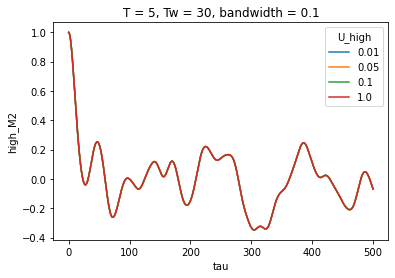

<Figure size 432x288 with 0 Axes>

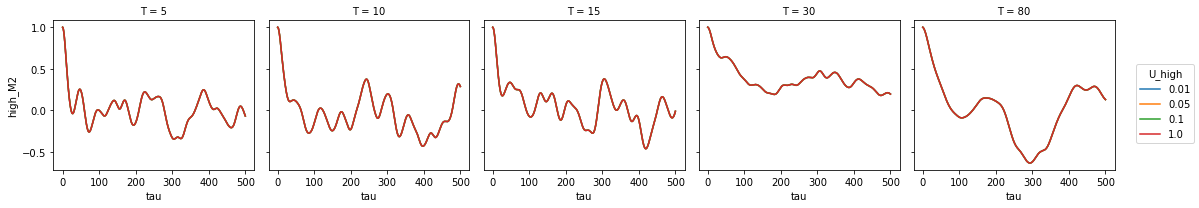

<Figure size 432x288 with 0 Axes>

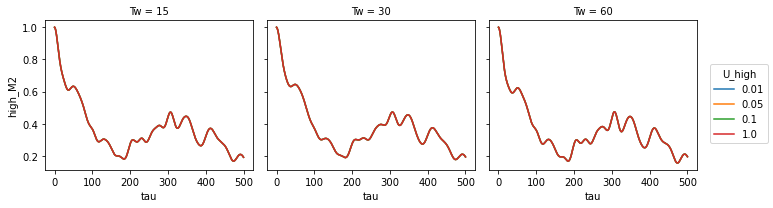

<Figure size 432x288 with 0 Axes>

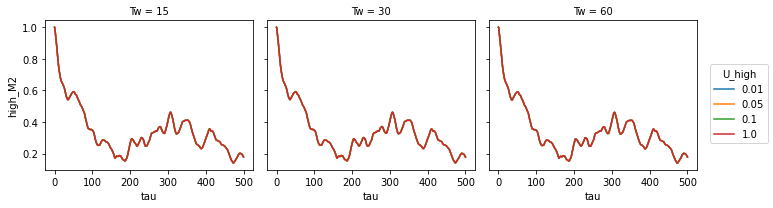

<Figure size 432x288 with 0 Axes>

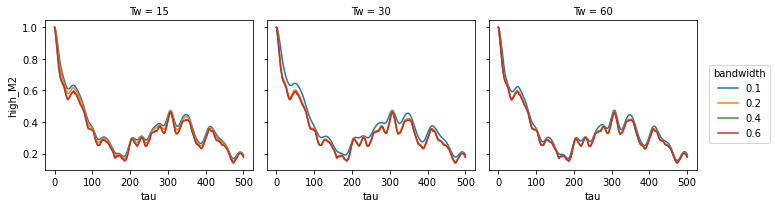

In [30]:
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30).plot(hue='U_high')
plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.6,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(T=30,U_high=0.1).plot(hue='bandwidth',col='Tw')

Notes : 

For large enough bandwidth compared to the decorrelation timescale, kernel length and bandwidth do not have impact on the results.

The form of autocovariance changes depending on the amplitude (mean over several samples should correct this).

NB : Short decorrealtion timescale compared to the band width ($\tilde T\leq T_\omega$) introduces oscillations in the autocovariance (expected)

#### High frequency signal (M2+S2)

<Figure size 432x288 with 0 Axes>

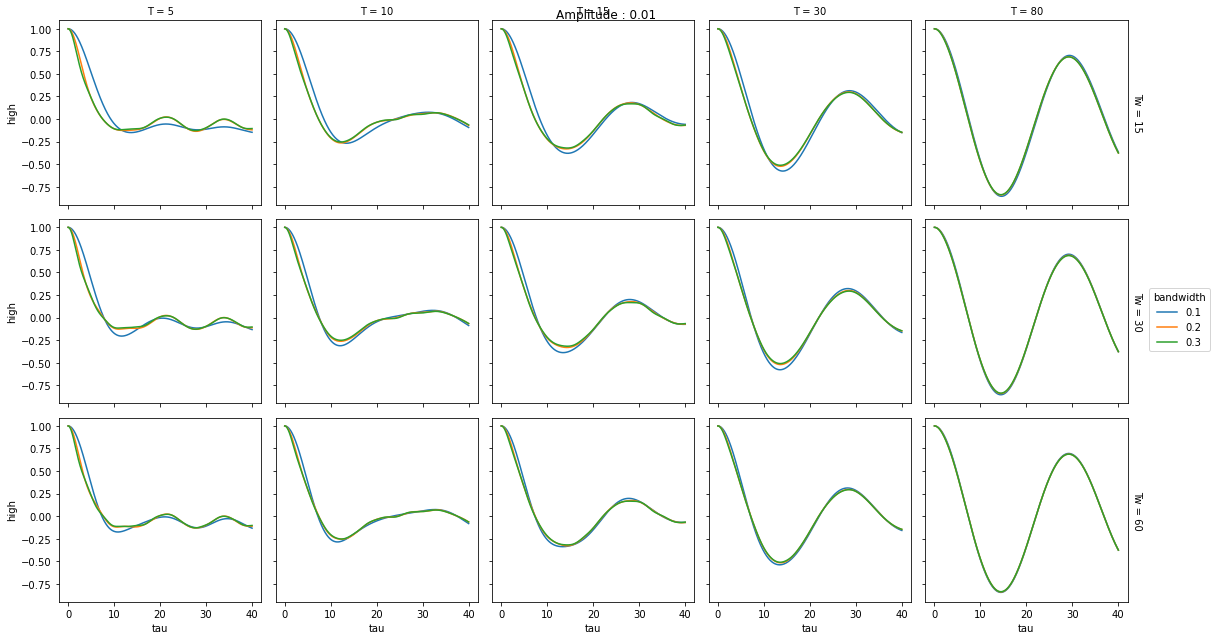

<Figure size 432x288 with 0 Axes>

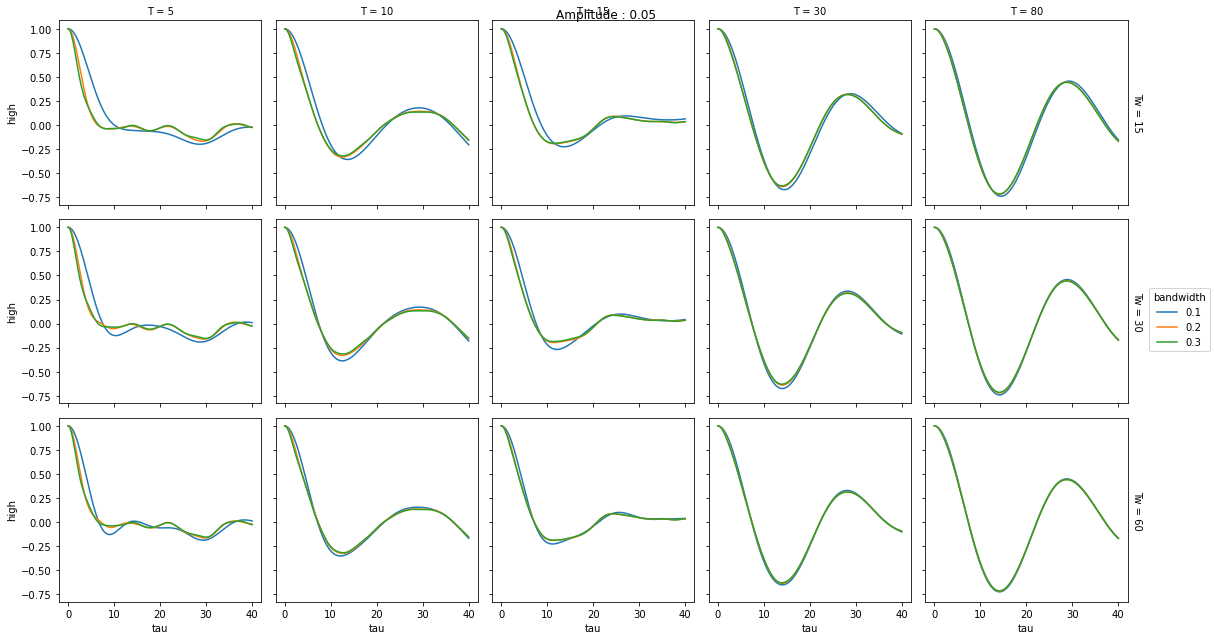

<Figure size 432x288 with 0 Axes>

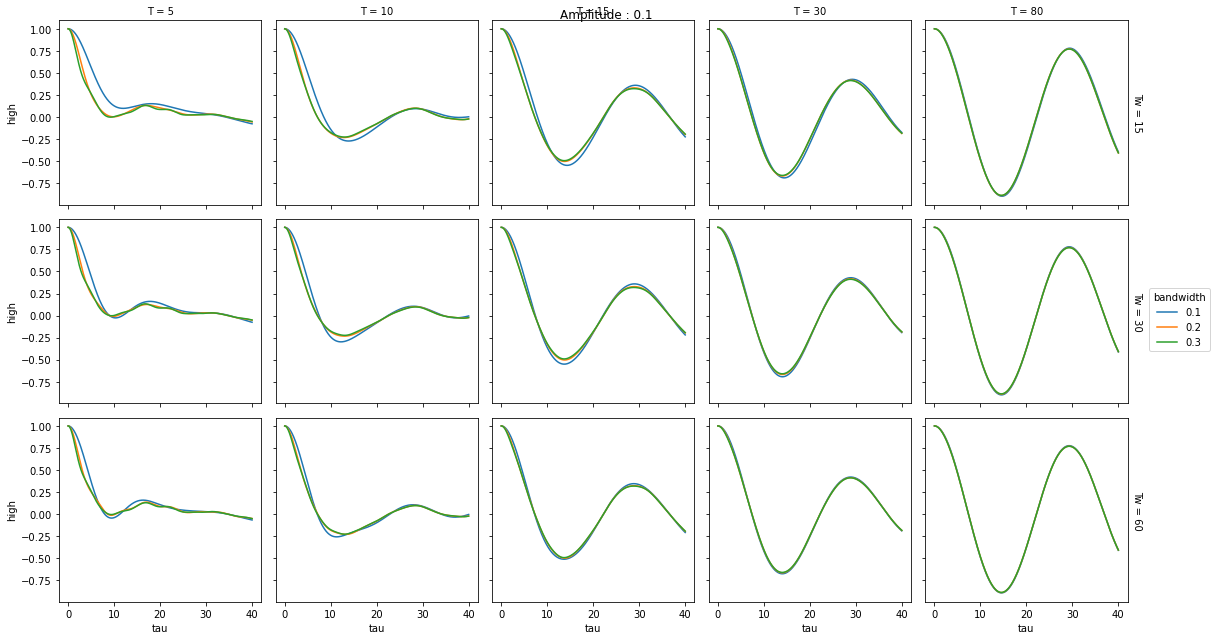

<Figure size 432x288 with 0 Axes>

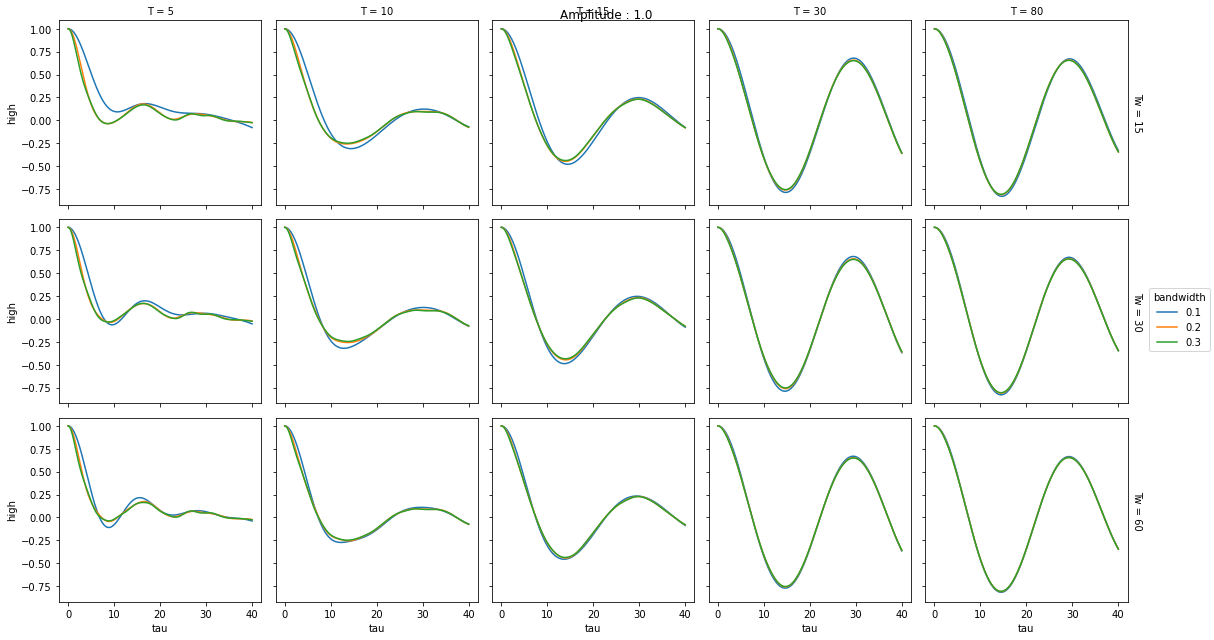

In [20]:
for U in ds_R.U_high:
    fig = plt.figure()
    (ds_R.high/ds_R.high.isel(tau=0)).sel(U_high=U).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()
    

Notes : 

Larger kernel size decreases the dependence to the bandwidth at fixed decorrelation timescale.

For decorrelation timescale of 5 days, the spring neap cycle is not captured anymore (osclliations at shorter period appears).

Form for decorrelation timescales changes depending on the amplitude (stronger for T=5days).

NB : Here one possible explaination for oscillations of period shorter than spring neap cycle is decorrelation timescale too small compared to the cycle, no significant impact of bandwidth, etc in the observed cases (we did not test very small kernel size that could introduce new problems).

Comparison to monochromatic signal : 

The oscillations observed for $\tilde T\leq T_\omega$ observed in the monochromatic case are not observed anymore. The fact that the decorrelation timescale is shorter than the spring neap cycle seems to have a dominiant effect and creates oscillations even in cases of large enough bandwidth ($\tilde T \geq T_\omega$)

### Several draw

In [12]:
nb_draws = 500
seed = 0
#T,T_low = [5,10,15,30,80],[5,15,30]
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
M2 = tseries("high_M2",draws=nb_draws,chunks={'draw':200,'T':-1},seed=seed).rename('M2')#,chunks={'draw':2}
S2 = tseries("high_S2",draws=nb_draws,chunks={'draw':200,'T':-1},seed=seed).rename('S2')# ,chunks={'draw':2}
#N2 = tseries("high_N2",draws=nb_draws).rename('N2')#,chunks={'draw':2}
#K2 = tseries("high_K2",draws=nb_draws).rename('K2')# ,chunks={'draw':2}
low = tseries("low",draws=nb_draws,chunks={'draw':200,'T':-1},seed=seed).rename({'T':'T_low'})#,chunks={'draw':4}

#da_high_M2 = da_high_M2.rename('high_M2')
#da_high_S2 = xr.concat([tseries("high_S2") for i in range(nb)],dim='sample'
#                      ).assign_coords({'sample':np.arange(0,nb)})
#da_high_S2 = da_high_S2.rename('high_S2')
#da_low = xr.concat([tseries("low") for i in range(nb)],dim='sample').assign_coords({'sample':np.arange(0,nb)})

In [12]:
M2.sel(draw=1).compute()

<xarray.DataArray 'M2' (T: 4, time: 12000)>
array([[ 0.03652919,  0.00295816, -0.0690608 , ...,  0.06036909,
        -0.23709986, -0.62556403],
       [-0.04401306, -0.03676896,  0.02962608, ..., -0.07674445,
         0.3215922 ,  0.73877563],
       [-0.04939688, -0.07426796, -0.10853266, ..., -0.55470668,
        -1.16885409, -1.5356013 ],
       [ 0.01143065, -0.02787285, -0.02945144, ...,  0.29987655,
         0.11982458, -0.10122823]])
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    draw     int64 1
Attributes:
    U:        [1.0]
    sigma:    12.140833182614747

In [13]:
low = low.sel(draw=M2.draw)
#M2 = M2.sel(draw=low.draw)
#S2 = S2.sel(draw=low.draw)

In [14]:
M2 = xr.concat([M2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})
S2 = xr.concat([S2*U for U in U_high],dim='U_high').assign_coords({'U_high':U_high})

In [15]:
low = low.chunk({'time':-1})
M2 = M2.chunk({'time':-1,'U_high':-1})
S2 = S2.chunk({'time':-1,'U_high':-1})
M2

<xarray.DataArray 'M2' (U_high: 4, T: 4, time: 12000, draw: 500)>
dask.array<rechunk-merge, shape=(4, 4, 12000, 500), dtype=float64, chunksize=(4, 4, 12000, 200), chunktype=numpy.ndarray>
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0

In [15]:
low

<xarray.DataArray 'low' (T_low: 3, time: 12000, draw: 500)>
dask.array<getitem, shape=(3, 12000, 500), dtype=float64, chunksize=(3, 12000, 200), chunktype=numpy.ndarray>
Coordinates:
  * T_low    (T_low) int64 5 30 100
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Attributes:
    U_low:    1.0

In [16]:
_M2,_low = xr.broadcast(M2,low)
_M2 = _M2.persist()
_low = _low.persist()

In [17]:
_S2 = xr.broadcast(_M2,S2)[1].persist()

In [18]:
_M2.sel(draw=1).compute()

<xarray.DataArray 'M2' (U_high: 4, T: 4, time: 12000, T_low: 3)>
array([[[[ 3.65291883e-04,  3.65291883e-04,  3.65291883e-04],
         [ 2.95815847e-05,  2.95815847e-05,  2.95815847e-05],
         [-6.90607980e-04, -6.90607980e-04, -6.90607980e-04],
         ...,
         [ 6.03690939e-04,  6.03690939e-04,  6.03690939e-04],
         [-2.37099863e-03, -2.37099863e-03, -2.37099863e-03],
         [-6.25564028e-03, -6.25564028e-03, -6.25564028e-03]],

        [[-4.40130625e-04, -4.40130625e-04, -4.40130625e-04],
         [-3.67689607e-04, -3.67689607e-04, -3.67689607e-04],
         [ 2.96260777e-04,  2.96260777e-04,  2.96260777e-04],
         ...,
         [-7.67444504e-04, -7.67444504e-04, -7.67444504e-04],
         [ 3.21592204e-03,  3.21592204e-03,  3.21592204e-03],
         [ 7.38775632e-03,  7.38775632e-03,  7.38775632e-03]],

        [[-4.93968751e-04, -4.93968751e-04, -4.93968751e-04],
         [-7.42679590e-04, -7.42679590e-04, -7.42679590e-04],
         [-1.08532664e-03, -1.08532664e-03, -1.08532664e-03],
         ...,
...
         ...,
         [-7.67444504e-02, -7.67444504e-02, -7.67444504e-02],
         [ 3.21592204e-01,  3.21592204e-01,  3.21592204e-01],
         [ 7.38775632e-01,  7.38775632e-01,  7.38775632e-01]],

        [[-4.93968751e-02, -4.93968751e-02, -4.93968751e-02],
         [-7.42679590e-02, -7.42679590e-02, -7.42679590e-02],
         [-1.08532664e-01, -1.08532664e-01, -1.08532664e-01],
         ...,
         [-5.54706680e-01, -5.54706680e-01, -5.54706680e-01],
         [-1.16885409e+00, -1.16885409e+00, -1.16885409e+00],
         [-1.53560130e+00, -1.53560130e+00, -1.53560130e+00]],

        [[ 1.14306475e-02,  1.14306475e-02,  1.14306475e-02],
         [-2.78728490e-02, -2.78728490e-02, -2.78728490e-02],
         [-2.94514387e-02, -2.94514387e-02, -2.94514387e-02],
         ...,
         [ 2.99876550e-01,  2.99876550e-01,  2.99876550e-01],
         [ 1.19824580e-01,  1.19824580e-01,  1.19824580e-01],
         [-1.01228226e-01, -1.01228226e-01, -1.01228226e-01]]]])
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    draw     int64 1
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100

In [19]:
ds = xr.merge([_M2,_S2, _low]).persist()
ds

<xarray.Dataset>
Dimensions:  (T: 4, time: 12000, draw: 500, U_high: 4, T_low: 3)
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100
Data variables:
    M2       (U_high, T, time, draw, T_low) float64 dask.array<chunksize=(4, 4, 12000, 200, 3), meta=np.ndarray>
    S2       (U_high, T, time, draw, T_low) float64 dask.array<chunksize=(4, 4, 12000, 200, 3), meta=np.ndarray>
    low      (U_high, T, time, draw, T_low) float64 dask.array<chunksize=(4, 4, 12000, 200, 3), meta=np.ndarray>

In [20]:
ds.M2.sel(draw=0).compute()

<xarray.DataArray 'M2' (U_high: 4, T: 4, time: 12000, T_low: 3)>
array([[[[ 1.61035210e-03,  1.61035210e-03,  1.61035210e-03],
         [ 5.66908344e-04,  5.66908344e-04,  5.66908344e-04],
         [ 4.55386822e-04,  4.55386822e-04,  4.55386822e-04],
         ...,
         [ 1.05658832e-02,  1.05658832e-02,  1.05658832e-02],
         [ 8.20472420e-03,  8.20472420e-03,  8.20472420e-03],
         [ 5.87660081e-03,  5.87660081e-03,  5.87660081e-03]],

        [[-3.91985003e-04, -3.91985003e-04, -3.91985003e-04],
         [ 2.27927647e-04,  2.27927647e-04,  2.27927647e-04],
         [ 3.40564039e-04,  3.40564039e-04,  3.40564039e-04],
         ...,
         [-1.05682419e-02, -1.05682419e-02, -1.05682419e-02],
         [-9.79281846e-03, -9.79281846e-03, -9.79281846e-03],
         [-6.55986796e-03, -6.55986796e-03, -6.55986796e-03]],

        [[-2.43797944e-04, -2.43797944e-04, -2.43797944e-04],
         [-1.53098415e-03, -1.53098415e-03, -1.53098415e-03],
         [-1.19444300e-03, -1.19444300e-03, -1.19444300e-03],
         ...,
...
         ...,
         [-1.05682419e+00, -1.05682419e+00, -1.05682419e+00],
         [-9.79281846e-01, -9.79281846e-01, -9.79281846e-01],
         [-6.55986796e-01, -6.55986796e-01, -6.55986796e-01]],

        [[-2.43797944e-02, -2.43797944e-02, -2.43797944e-02],
         [-1.53098415e-01, -1.53098415e-01, -1.53098415e-01],
         [-1.19444300e-01, -1.19444300e-01, -1.19444300e-01],
         ...,
         [-4.03082615e-01, -4.03082615e-01, -4.03082615e-01],
         [-5.54580605e-01, -5.54580605e-01, -5.54580605e-01],
         [-5.40669371e-01, -5.40669371e-01, -5.40669371e-01]],

        [[ 3.58394654e-03,  3.58394654e-03,  3.58394654e-03],
         [ 9.44702491e-03,  9.44702491e-03,  9.44702491e-03],
         [-3.22931587e-02, -3.22931587e-02, -3.22931587e-02],
         ...,
         [ 8.05574260e-01,  8.05574260e-01,  8.05574260e-01],
         [ 2.40948858e-01,  2.40948858e-01,  2.40948858e-01],
         [-4.04653491e-01, -4.04653491e-01, -4.04653491e-01]]]])
Coordinates:
  * T        (T) int64 5 15 30 80
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    draw     int64 0
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * T_low    (T_low) int64 5 30 100

In [68]:
ds = xr.broadcast(ds)[0].persist()

In [20]:
ds['high_MS'] = ds.M2+ds.S2
#ds_stat['high_MSNK'] = ds_stat.M2+ds_stat.S2+ds_stat.N2+ds_stat.K2
ds['total'] = ds.M2+ds.S2+ds.low
#ds_stat['total_NK'] = ds_stat.M2+ds_stat.S2+ds_stat.N2+ds_stat.K2+ds_stat.low

In [21]:
ds = ds.persist()

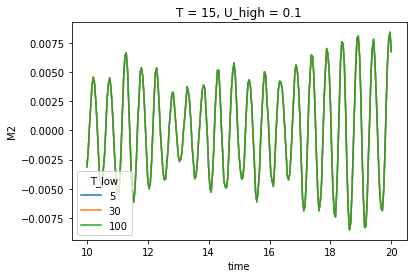

In [22]:
ds.M2.isel(T=1).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(label='M2',hue='T_low')



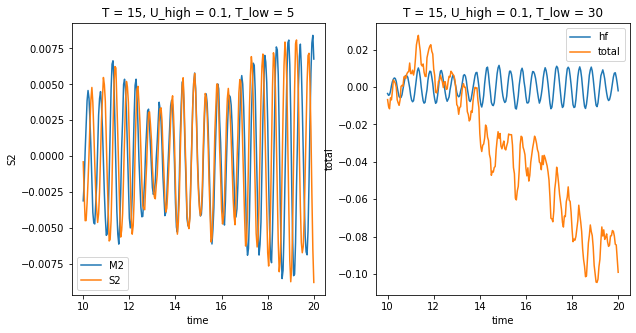

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds.M2.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(ax=ax[0],label='M2')
ds.S2.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(ax=ax[0],label='S2')
ax[0].legend()
ds.high_MS.isel(T=1,T_low=0).sel(U_high=0.1).sel(time=slice(10,20)).mean('draw').plot(ax=ax[1],label='hf')
ds.total.isel(T_low=1,T=1,U_high=2).sel(time=slice(10,20)).mean('draw').plot(ax=ax[1],label='total')
ax[1].legend()

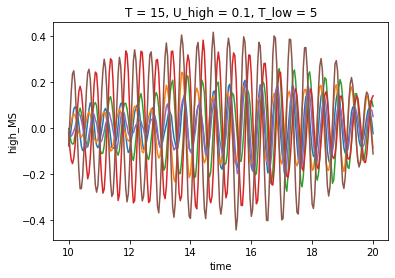

In [24]:
ds.high_MS.isel(T=1,U_high=2,T_low=0).sel(time=slice(10,20),draw=slice(0,5)).plot(hue='draw',add_legend=False)

#ds_stat.high.isel(T=1,U_high=2).sel(time=slice(100,120)).isel(draw=4).plot()

In [24]:
#Tw = [15,30,60]
#band = [0.1,0.2,0.3]
kind  = ['M2','S2','high_MS','total']
_ds_stat = {}
for om,k in zip([omega_M2,omega_S2,omega,omega],kind):
    _ds_stat[k] = xr.combine_nested([[sigp.bpass_demodulate(ds[[k]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':[d*2 for d in dband]})#.compute()

In [25]:
stat = xr.merge([_ds_stat[k].drop('exp') for k in kind])

In [27]:
for k in kind:
    stat[k+'_demodulated_tmean'] = np.abs(stat[k+'_demodulated']).mean('time')
    stat[k+'_amplitude'] = np.abs(stat[k+'_demodulated'])-stat[k+'_demodulated_tmean']
    stat[k+'_var0'] = stat[k+'_amplitude']**2
    stat[k+'_var1'] = np.abs(stat[k+'_demodulated']).var('time')

In [26]:
stat

,Array,Chunk
Bytes,25.75 GiB,878.91 MiB
Shape,"(3, 4, 4, 4, 12000, 500, 3)","(1, 1, 4, 4, 12000, 200, 3)"
Count,66 Tasks,36 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,51.50 GiB,1.72 GiB
Shape,"(3, 4, 4, 4, 500, 3, 12000)","(1, 1, 4, 4, 200, 3, 12000)"
Count,180 Tasks,36 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk


In [29]:
#ds["sigma0_hat"] = u.var("time")*sigma_correction

sigma0_hat = 0.5*np.abs(stat.high_MS_demodulated)**2

In [31]:
sigma0_hat = sigma0_hat.persist()

In [32]:
sigma0_hat.to_netcdf('/home1/datawork/zcaspar/mit4320/sigma0_500.nc')

In [27]:
for k in kind:
    stat[k+'_bpassed_real'] = np.real(stat[k+'_bpassed'])
    stat[k+'_demodulated_real'] = np.real(stat[k+'_demodulated'])
stat = stat.persist()

In [28]:
stat_mean = {}
for k in kind : 
    stat_mean[k+'_var'] = stat[k].var('time').mean('draw')
#    stat_mean[k+'_mean'] = stat[k].mean(['time','draw'])
    stat_mean[k+'_bpassed_var'] = stat[k+'_bpassed_real'].var('time').mean('draw')
#    stat_mean[k+'_bpassed_mean'] = stat[k+'_bpassed_real'].mean(['time','draw'])
    stat_mean[k+'_demodulated_var'] = stat[k+'_demodulated_real'].var('time').mean('draw')
    stat_mean[k+'_demodulated_energy'] = (np.abs(stat[k+'_demodulated'])**2).mean(['time','draw'])
#    stat_mean[k+'_demodulated_mean'] = stat[k+'_demodulated_real'].mean(['time','draw'])
#    stat_mean = stat_mean.persist()
#    stat_mean[k+'_demodulated_var'] = np.abs(stat[k+'_demodulated']).mean(['time','draw'])
#    stat_mean[k+'_var0'] = stat[k+'_var0'].mean(['time','draw'])
#    stat_mean[k+'_var1'] = stat[k+'_var1'].mean('draw')

In [29]:
stat_mean.keys()

dict_keys(['M2_var', 'M2_bpassed_var', 'M2_demodulated_var', 'M2_demodulated_energy', 'S2_var', 'S2_bpassed_var', 'S2_demodulated_var', 'S2_demodulated_energy', 'high_MS_var', 'high_MS_bpassed_var', 'high_MS_demodulated_var', 'high_MS_demodulated_energy', 'total_var', 'total_bpassed_var', 'total_demodulated_var', 'total_demodulated_energy'])

In [30]:
mstat = xr.merge([stat_mean[key].rename(key) for key in stat_mean.keys()]).persist()

In [31]:
mstat

<xarray.Dataset>
Dimensions:                     (T: 4, U_high: 5, T_low: 3, Tw: 3, bandwidth: 4)
Coordinates:
  * T                           (T) int64 5 15 30 80
  * U_high                      (U_high) float64 0.01 0.05 0.1 1.0 2.0
  * T_low                       (T_low) int64 5 30 100
  * Tw                          (Tw) int64 15 30 60
  * bandwidth                   (bandwidth) float64 0.1 0.2 0.4 0.6
Data variables: (12/16)
    M2_var                      (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    M2_bpassed_var              (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    M2_demodulated_var          (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    M2_demodulated_energy       (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    S2_var                      (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    S2_bpassed_var              (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    ...                          ...
    high_MS_demodulated_var     (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    high_MS_demodulated_energy  (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    total_var                   (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    total_bpassed_var           (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    total_demodulated_var       (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>
    total_demodulated_energy    (Tw, bandwidth, U_high, T, T_low) float64 dask.array<chunksize=(1, 1, 5, 4, 3), meta=np.ndarray>

<Figure size 432x288 with 0 Axes>

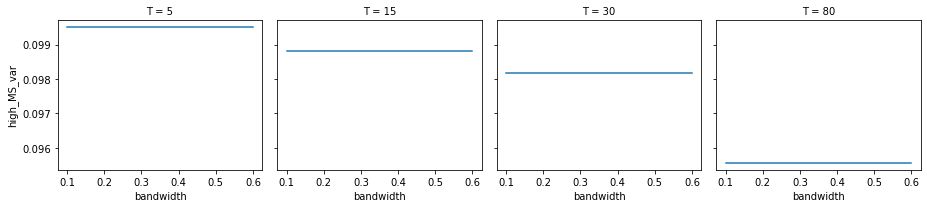

<Figure size 432x288 with 0 Axes>

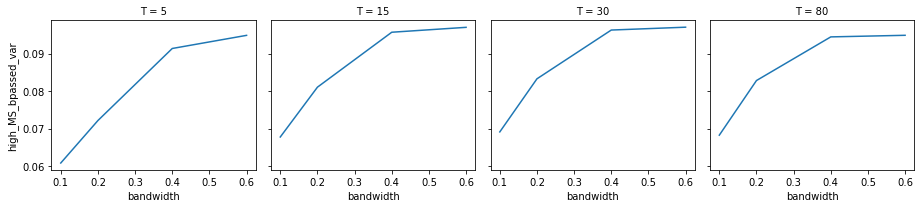

<Figure size 432x288 with 0 Axes>

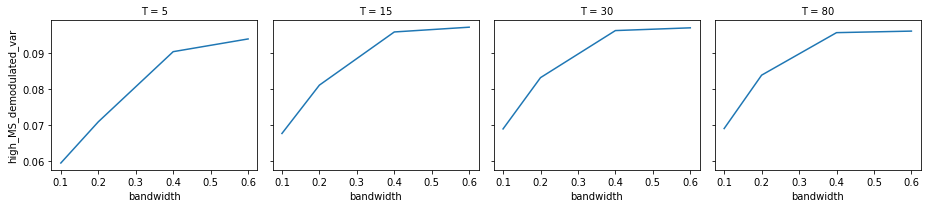

In [31]:
#mstat.sel(U_high=0.1,Tw=15,T_low=30).high_MS_mean.plot(col='T')
plt.figure()
np.sqrt(mstat.sel(U_high=0.1,Tw=15,T_low=30)).high_MS_var.plot(col='T')
plt.figure()
np.sqrt(mstat.sel(U_high=0.1,Tw=15,T_low=30)).high_MS_bpassed_var.plot(col='T')
plt.figure()
np.sqrt(mstat.sel(U_high=0.1,Tw=15,T_low=30)).high_MS_demodulated_var.plot(col='T')

In [33]:
mstat.to_netcdf('/home1/datawork/zcaspar/mit4320/variance_500.nc')

In [34]:
del mstat

In [35]:
stat_mean = {}
for k in kind : 
    stat_mean[k+'_mean'] = stat[k].mean(['time','draw'])
    stat_mean[k+'_bpassed_mean'] = stat[k+'_bpassed_real'].mean(['time','draw'])
    stat_mean[k+'_demodulated_mean'] = stat[k+'_demodulated_real'].mean(['time','draw'])

In [36]:
mstat = xr.merge([stat_mean[key].rename(key) for key in stat_mean.keys()]).persist()

In [37]:
mstat.to_netcdf('/home1/datawork/zcaspar/mit4320/mean_500.nc')

In [45]:
for k in kind:
    _ds_stat[k] = _ds_stat[k].sel(time=slice(0,80)).persist()

In [87]:
R_stat = {}
maxlag = t_size
lags = np.arange(0,maxlag//2,1/24)
for k in kind:
    R_stat[k] = autocorrelations(_ds_stat[k],[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})

/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp.py:126: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,


In [88]:
ds_R_stat = xr.merge([R_stat[k] for k in kind]) #,'total'

In [90]:
del stat_mean

In [ ]:
xr.merge([ds_R_stat,R_low])

In [91]:
ds_R_mean = ds_R_stat.mean('draw')

In [92]:
ds_R_mean = ds_R_mean.persist()

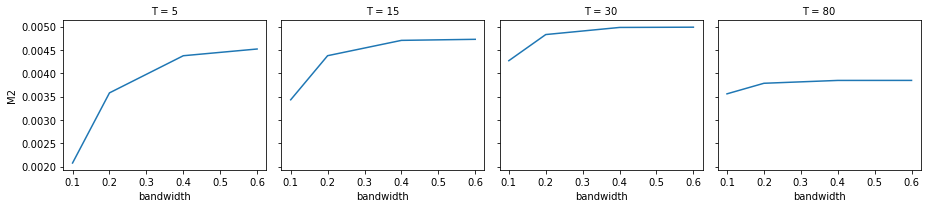

In [50]:
ds_R_mean.sel(tau=0,U_high=0.1,Tw=30,T_low=5).M2.plot(col='T')

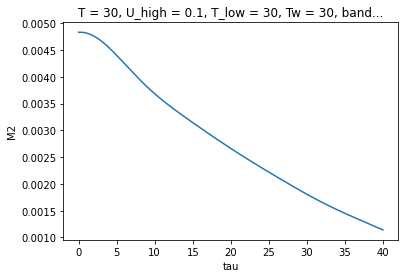

In [51]:
ds_R_mean.sel(T=30,Tw=30,U_high=0.1,bandwidth=0.2,T_low=30).M2.sel(tau=slice(0,40)).plot()

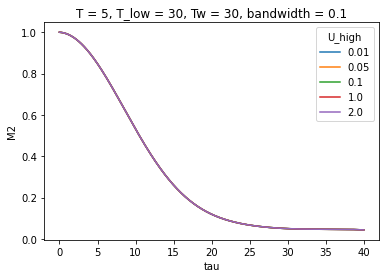

<Figure size 432x288 with 0 Axes>

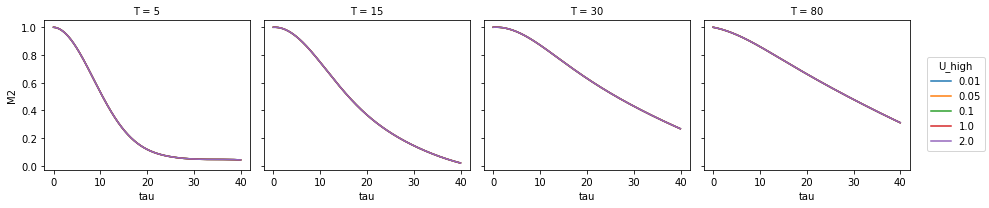

<Figure size 432x288 with 0 Axes>

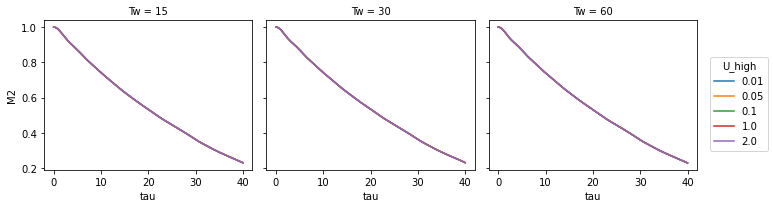

<Figure size 432x288 with 0 Axes>

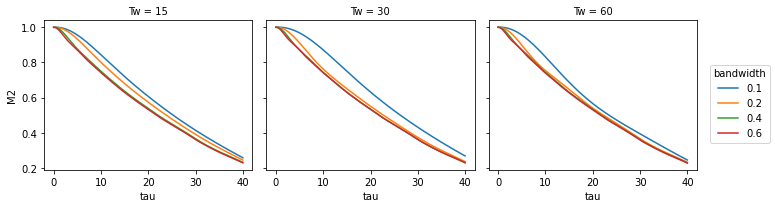

In [52]:
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30,T_low=30).plot(hue='U_high')
plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30,T_low=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(bandwidth=0.6,T=30,T_low=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R_mean.M2/ds_R_mean.M2.isel(tau=0)).sel(T=30,U_high=0.1,T_low=30).plot(hue='bandwidth',col='Tw')

In [53]:
ds_R_mean = ds_R_mean.compute()

In [54]:
ds_R_mean.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_500_U_valid_80.nc')

In [40]:
[_ds_stat[_].drop('exp') for _ in _ds_stat.keys()]

[<xarray.Dataset>
 Dimensions:         (Tw: 3, bandwidth: 4, T: 5, time: 1920, draw: 1000, U_high: 4, T_low: 3)
 Coordinates:
   * T               (T) int64 5 10 15 30 80
   * time            (time) float64 0.0 0.04167 0.08333 ... 79.88 79.92 79.96
   * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
   * U_high          (U_high) float64 0.01 0.05 0.1 1.0
   * T_low           (T_low) int64 5 30 100
   * Tw              (Tw) int64 15 30 60
   * bandwidth       (bandwidth) float64 0.1 0.2 0.4 0.6
 Data variables:
     M2              (Tw, bandwidth, T, time, draw, U_high, T_low) float64 dask.array<chunksize=(1, 1, 5, 1920, 1000, 1, 3), meta=np.ndarray>
     M2_bpassed      (Tw, bandwidth, T, draw, U_high, T_low, time) complex128 dask.array<chunksize=(1, 1, 5, 1000, 1, 3, 1920), meta=np.ndarray>
     M2_demodulated  (Tw, bandwidth, T, draw, U_high, T_low, time) complex128 dask.array<chunksize=(1, 1, 5, 1000, 1, 3, 1920), meta=np.ndarray>,
 <xarray.Dataset>
 Di

In [29]:
_ds_stat = xr.merge([_ds_stat[_].drop('exp') for _ in _ds_stat.keys()])

In [30]:
for k in kind:
    _ds_stat[k+'_bpassed_real'] = _ds_stat[k+'_bpassed'].real
    _ds_stat[k+'_bpassed_imag'] = _ds_stat[k+'_bpassed'].imag
    _ds_stat[k+'_demodulated_real'] = _ds_stat[k+'_demodulated'].real
    _ds_stat[k+'_demodulated_imag'] = _ds_stat[k+'_demodulated'].imag
    _ds_stat = _ds_stat.drop([k+'_bpassed',k+'_demodulated'])
_ds_stat = _ds_stat.persist()

In [ ]:
_ds_stat.to_netcdf('/home1/datawork/zcaspar/mit4320/filtered_1000_T80.nc')

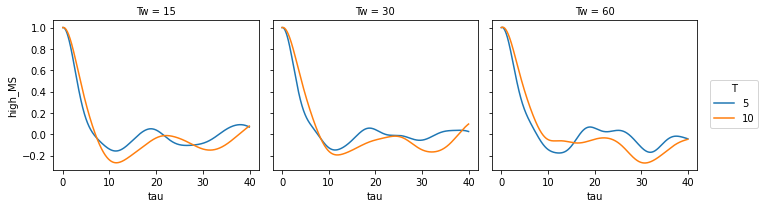

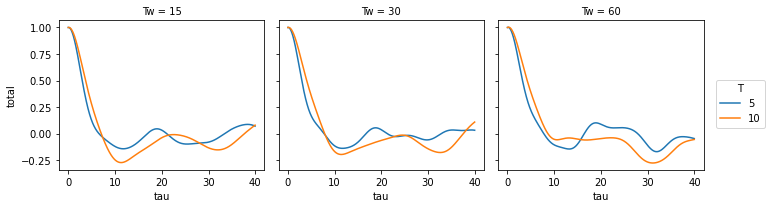

In [35]:
(ds_R_mean['high_MS']/ds_R_mean['high_MS'].isel(tau=0)).sel(U_high=0.1,T_low=30,bandwidth=0.4).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

(ds_R_mean['total']/ds_R_mean['total'].isel(tau=0)).sel(U_high=0.1,T_low=30,bandwidth=0.4).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

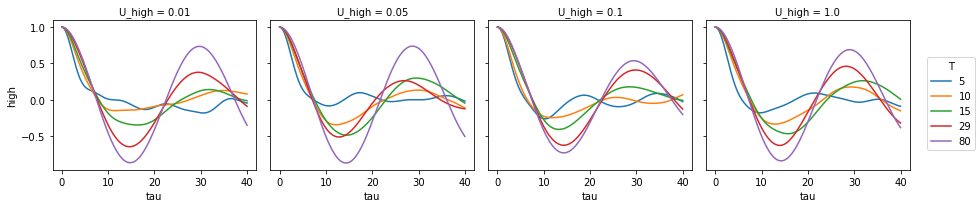

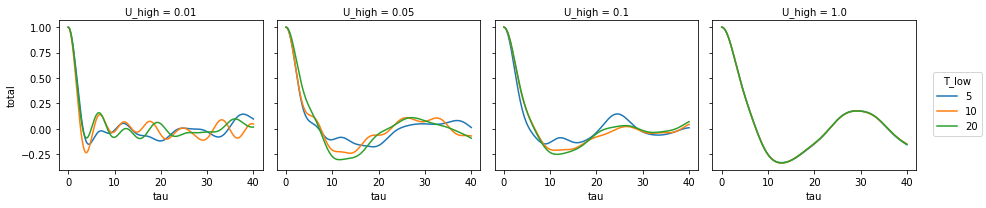

In [96]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(Tw=30).sel(tau=slice(0,40)).plot(hue='T',col='U_high')
(ds_R['total']/ds_R['total'].isel(tau=0)).sel(T=10,Tw=30).sel(tau=slice(0,40)).plot(hue='T_low',col='U_high')

In [57]:
#client.restart()
#
cluster.close()